# Phylonium - fast and accurate estimation of evolutionary distances

### Phyloium needs all input fasta to be splited in different fasta files, one could do it by using pyfastx

In [28]:
! grep -c ">" nextclade.Brazil.sub.3k/Brazil.sub.3k.fasta

2951


Maybe in your unix-like system it is requeired to increase ulimit do deal with thousands of files at the same time

In [ ]:
ulimit -n 60000

In [ ]:
! pyfastx split -n 2951 -o output_splited/ nextclade.Brazil.sub.3k/Brazil.sub.3k.fasta

In [ ]:
! cd output_splited/

In [ ]:
! phylonium *.fasta > br_phylo/Brazil.sub.3k.out2

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R
library(ggtree)
library(phangorn)
library(tidyverse)
library(treeio)
library(ape)
library(phyloTop)
library(stylo)
library(dendextend)

In [18]:
%%R
colors_scale = c(
  '19A' = "tan", '19B' = "palegreen1",
  '20A' = "palegreen3", '20B' = "chartreuse4", '20C' = "salmon2", '20G' = "sandybrown",
  '20I (Alpha, V1)' = "turquoise2", '20J (Gamma, V3)' = "darkorange",
  '21A (Delta)' = "royalblue1", '21I (Delta)' = "royalblue2", '21J (Delta)' = "royalblue3",    
  '21K (Omicron)' = "red1", '21L (Omicron)' = "red2",
  '22A (Omicron)' = "firebrick1", '22B (Omicron)' = "firebrick2", '22C (Omicron)' = "firebrick4",
  'recombinant' = "yellow"
)


## Reading phyloriun distance matrix

In [20]:
%%R
phydist = readDist("br_phylo/Brazil.sub.3k.out2", format = "phylip")
class(phydist)


[1] "dist"


## Estimating tree

In [21]:
%%R
nj_phy = nj(phydist)

## Reading data from ML tree, it's metadata and formatting tip names to match with phylonium output 

In [22]:
%%R

meta = read.csv("nextclade.Brazil.sub.3k/Brazil.sub.3k.nextclade.tsv", sep="\t", stringsAsFactors = F)
names(meta)[1] = "label"
meta$label = gsub("/","_", meta$label)

tree = read.iqtree("nextclade.Brazil.sub.3k/Brazil.sub.3k.aligned.fasta.contree") 
tree = as.phylo(tree)

tree$tip.label = gsub("/","_", tree$tip.label)


## Printing trees

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


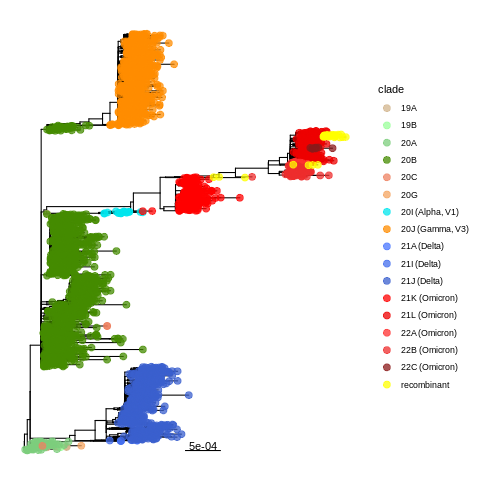

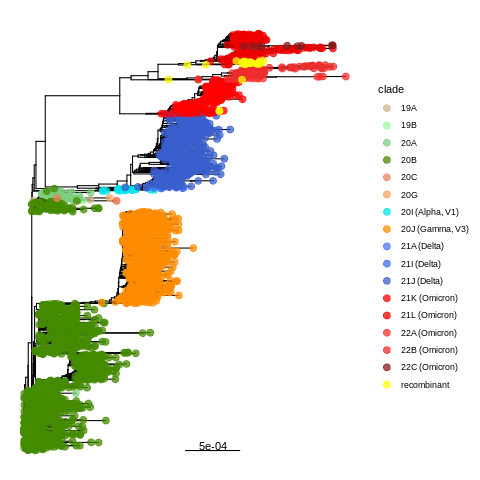

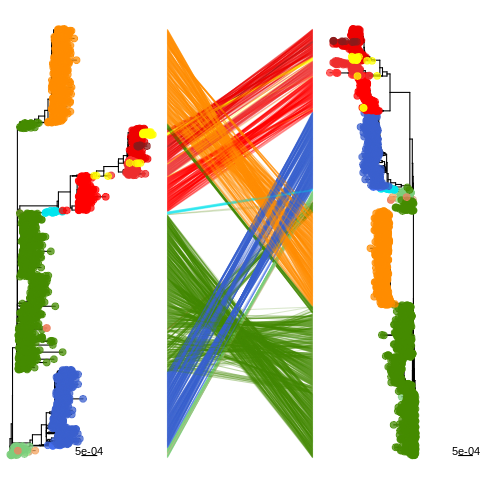

In [27]:
%%R


p = ggtree(tree, ladderize = T)

p$data %>%
  ggplot(aes(x=UFboot)) +
  geom_histogram( binwidth=3, fill="#69b3a2", color="#e9ecef", alpha=0.9)



p$data = left_join(p$data, meta, by="label") 
p1 = p + geom_tippoint(aes(color = clade), alpha = 0.75, size = 3) +
  geom_treescale(width=0.0005, color='black') + 
  theme(legend.position="right") +
  scale_color_manual(values= colors_scale) + 
  ylim(-0.3,3000)

plot(p1)

p = ggtree(nj_phy, ladderize = T)
p$data = left_join(p$data, meta, by="label") 
p11 = p + geom_tippoint(aes(color = clade), alpha = 0.75, size = 3) +
  geom_treescale(width=0.0005, color='black') + 
  theme(legend.position="right") +
  scale_color_manual(values= colors_scale) + 
  ylim(-0.3,3000)

plot(p11)

svg("FIG_tree_filorium2.svg",width = 30, height = 40)
plot(p11)
dev.off()


T1 <- p1 + theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm"))

T2 <- p11 +  
  scale_x_reverse()+ theme(legend.position="rigth", plot.margin = unit(c(0,0,0,0),"cm")) 

d1 = T1$data[T1$data$isTip,]
d1$x[] = 1  

d2 = T2$data[T2$data$isTip,]  
d2$x[] = 2  

TTcon <- rbind(d1, d2)  

L1 = ggplot(TTcon, aes(x = x, y = y, col = clade, group = label)) +
  geom_line(alpha = 0.2) + theme_void() + 
  theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm")) +
  scale_color_manual(values=colors_scale) + 
  ylim(-0.3,3000)

svg("FIG_tanglegrama_filorium.svg",width = 20, height = 10)
plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))
dev.off()

plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))


## Statistics

In [25]:
%%R
print(cor_cophenetic(nj_phy, phydist, method_coef = "spearman"))
print(cor_cophenetic(nj_phy, as.phylo(tree), method_coef = "spearman"))
print(RF.dist(nj_phy,as.phylo(tree), normalize = T))
print(phyloTop(c(nj_phy), normalise = F))

[1] 0.989334
[1] 0.9725789


R[write to console]: Trees are not binary!



[1] 0.6540345
  avgLadder cherries colless.phylo ILnumber maxHeight pitchforks sackin.phylo
1  3.154839      802        145257     1346       112        410       165565
    stairs1   stairs2
1 0.7056629 0.4989577
